In [215]:
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import numpy as np
%matplotlib inline

# Part 1: Pre-Processing and cutting .wav file into chunks

### Load the .wav audio file

In [216]:
filename = 'filler'
wave, fs = librosa.load(filename+'.wav')

### Visualize the amplitude in time domain

Frequency: 22050
Duration: 8.95201814058957 s


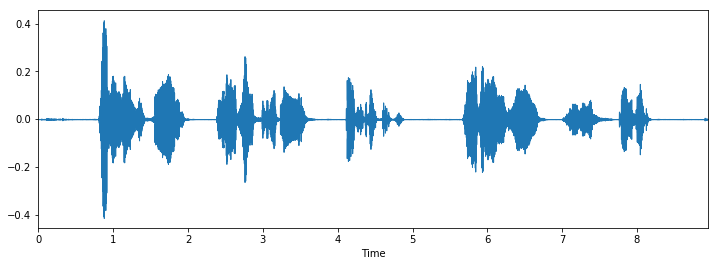

In [217]:
print("Frequency:",fs)
print("Duration:",len(wave)/fs,"s")

plt.figure(figsize=(12, 4))
librosa.display.waveplot(wave, sr=fs)

In [161]:
ipd.Audio(wave, rate=fs)

### 0. Trim the leading silence portion

#### Source: https://musicinformationretrieval.com/energy.html

In [190]:
def strip(x, frame_length, hop_length):

    # Compute RMSE.
    rmse = librosa.feature.rmse(x, frame_length=frame_length, hop_length=hop_length, center=True)
    
    # Identify the first frame index where RMSE exceeds a threshold.
    thresh = 0.01
    frame_index = 0
    while rmse[0][frame_index] < thresh:
        frame_index += 1
        
    # Convert units of frames to samples.
    start_sample_index = librosa.frames_to_samples(frame_index, hop_length=hop_length)
    
    # Return the trimmed signal.
    return x[start_sample_index:]

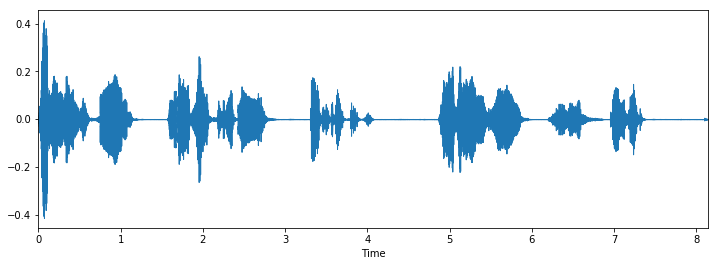

In [193]:
wave = strip(wave, 20, 10) #Trim with 20ms frame length and 10ms hop length
plt.figure(figsize=(12, 4))
librosa.display.waveplot(y, sr=fs)

### End-point detection (VAD) 

#### Detecting the start point and end point of voice activity

#### Source: https://www.kaggle.com/jerrypeng/dsp-tutorial-3-demos-for-speech-processing

### 1. Calculate RMS and Zero Crossing Rate

In [165]:
frame_len = int(40 * fs /1000) # 20ms
frame_shift = int(10 * fs /1000) # 10ms
# calculate RMS
rms = librosa.feature.rmse(wave, frame_length=frame_len, hop_length=frame_shift)
rms = rms[0]
rms = librosa.util.normalize(rms, axis=0)

# calculate zero-crossing rate
zrc = librosa.feature.zero_crossing_rate(wave, frame_length=frame_len, hop_length=frame_shift, threshold=0)
zrc = zrc[0]
#zrc = librosa.util.normalize(zrc, axis=0)

### 2. Visualize the amplitude with RMS Energy and Zero Crossing Rate

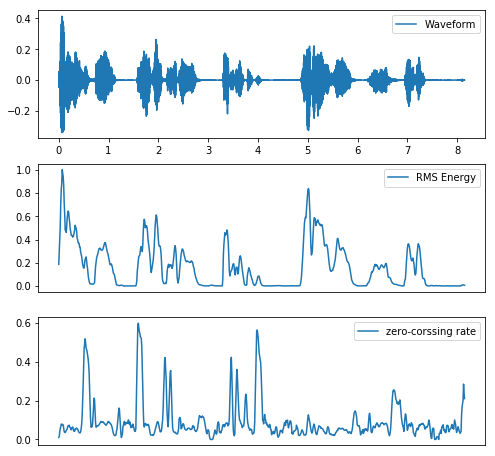

In [194]:
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
t = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(t, wave, label='Waveform')
plt.legend(loc='best')

plt.subplot(3, 1, 2)
plt.plot(rms.T, label='RMS Energy')
plt.xticks([])
plt.legend(loc='best')

plt.subplot(3, 1, 3)
plt.plot(zrc.T, label='zero-corssing rate')
plt.xticks([])
plt.legend(loc='best')
plt.show()

### 3. Set threshold of speech and silence

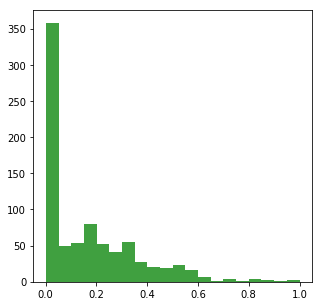

In [195]:
plt.figure(figsize=(5, 5))
n, bins, patches = plt.hist(rms.T, 20, facecolor='g', alpha=0.75)

Based on the histogram above, we can set threshold of RMS at 0.1 and 0.5 for zrc.

In [196]:
frame_idxs = np.where( (rms > 0.1) | (zrc > 0.5) )[0]

### 4. Based on the frame indices, get start and end points of frames

In [197]:
def getboundaries(frame_idxs):
    #get the first frame index
    start_idxs = [frame_idxs[0]]
    end_idxs = []

    #get the length of list of frame indices
    shapeofidxs = np.shape(frame_idxs)

    #for each index in the list 
    for i in range(shapeofidxs[0]-1):
        #if the next index is in a different frame (difference > 1)
        if (frame_idxs[i + 1] - frame_idxs[i]) != 1:
            #i is an end index 
            end_idxs.append(frame_idxs[i])
            #i+1 is a start index
            start_idxs.append(frame_idxs[i+1])
            
    #last index of the list will be an end index
    end_idxs.append(frame_idxs[-1])
    
    # del the last boundaries if it is both start point and end point.
    if end_idxs[-1] == start_idxs[-1]:
        end_idxs.pop()
        start_idxs.pop()
    assert len(start_idxs) == len(end_idxs), 'Error! Num of start_idxs doesnt match Num of end_idxs.'
    
    #convert into np.array
    start_idxs = np.array(start_idxs)
    end_idxs = np.array(end_idxs)
    
    #from index, convert to time 
    start_t = start_idxs * frame_shift / fs
    end_t = end_idxs * frame_shift / fs
    return start_t, end_t

In [198]:
start_t, end_t = getboundaries(frame_idxs)
print("Number of frames: ", len(start_t))

Number of frames:  14


### 5. Visualize the wave with frames (Red: start, Green: end)

Problem: The start and end time periods yielded out from getBoundaries do not match with the time domain so that we can iterate through wave file and save all the points of a frame 

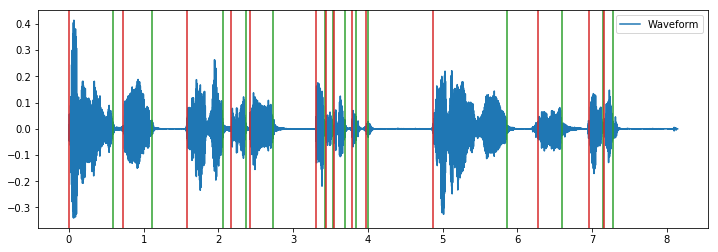

In [171]:
plt.figure(figsize=(12, 4))
t = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(t, wave, label='Waveform')
for s, e in zip(start_t, end_t):
    plt.axvline(x=s, color='#d62728') # red vertical line
    plt.axvline(x=e, color='#2ca02c') # green vertical line
plt.legend(loc='best')
plt.show()

### 6. Reformate the time frame limits computed by the algorithms (to be consistence with the wave's time domain)

In [201]:
#Reformat the time frame limits computed by the algorithms 

#Cut down to 10 decimal place, used to be 16
start_t = [(float("{0:.10f}".format(x))) for x in start_t]
end_t = [(float("{0:.10f}".format(i))) for i in end_t]

#Compare with the real timeline of the file, take the time period nearest to 4 decimal place 
s = 0
e = 0
#Retrieve the time frame correspond to the real time graph
new_start = []
new_end = []
time = np.linspace(0, len(wave)/fs, len(wave))
time = [(float("{0:.10f}".format(a))) for a in time]
for t in time: 
    if s < len(start_t) and abs(start_t[s]-t) < 0.0001:
        print("start","algo: ", start_t[s],"    " ,"original from graph: ", t)
        new_start.append(t)
        s = s + 1
    elif e < len(end_t) and abs(end_t[e]-t) < 0.0001:
        print(" end","algo: ", end_t[e], "    ","original from graph: ", t)
        new_end.append(t)
        e = e + 1

start algo:  0.0      original from graph:  0.0
 end algo:  0.5886621315      original from graph:  0.5885747053
start algo:  0.7283446712      original from graph:  0.7282580226
 end algo:  1.1074829932      original from graph:  1.1073984554
start algo:  1.5764172336      original from graph:  1.5763353065
 end algo:  2.0653061224      original from graph:  2.0652269171
start algo:  2.1750566893      original from graph:  2.174978095
 end algo:  2.3646258503      original from graph:  2.3645483114
start algo:  2.4244897959      original from graph:  2.4244125903
 end algo:  2.7337868481      original from graph:  2.7337113644
start algo:  3.3024943311      original from graph:  3.3024220135
 end algo:  3.4222222222      original from graph:  3.4221505712
start algo:  3.4421768707      original from graph:  3.4421053309
 end algo:  3.5319727891      original from graph:  3.5319017491
start algo:  3.5519274376      original from graph:  3.5518565088
 end algo:  3.6916099773      origin

### 7. Redraw the graph

Just to make sure there's no huge discrepency


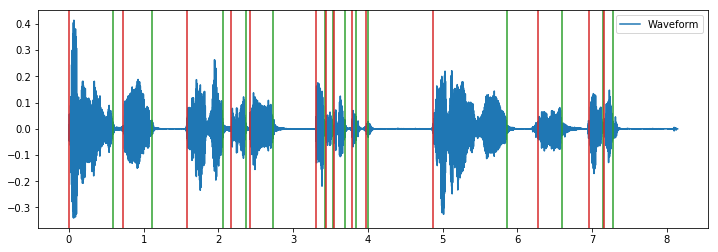

In [202]:
#Redraw the graph
plt.figure(figsize=(12, 4))
time = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(time, wave, label='Waveform')
for s, e in zip(new_start, new_end):
    plt.axvline(x=s, color='#d62728') # red vertical line
    plt.axvline(x=e, color='#2ca02c') # green vertical line
plt.legend(loc='best')
plt.show()

### 8. Cut the original wave file into chunks corresponding the computed frame 

In [174]:
#Cut the original wave file into chunks corresponding the computed frame 
chunks = []
frame = []
inFrame = False
frame_idx = 0
num_frames = len(new_start)
time = np.linspace(0, len(wave)/fs, len(wave))
time = [(float("{0:.10f}".format(a))) for a in time]
for w,t in zip(wave,time):
    #if t is the beginning of a frame
    if t == new_start[frame_idx]:
        print("Start Frame!",t)
        #raise the inFrame flag, start collecting the wave
        inFrame = True
    #if t is the end of a frame
    elif t == new_end[frame_idx]:
        print("End Frame!",t)
        #collect the last value
        frame.append(w)
        #add the frame to the chunks
        chunks.append(frame)
        #reset the frame 
        frame = []
        #increment the frame index 
        frame_idx += 1
        #unflag the inFrame flag, stop collecting the wave
        inFrame = False
    #if t is somewhere in the frame, collect it
    if inFrame == True: 
        frame.append(w)
    #if no frame left to search for, break
    if frame_idx == num_frames:
        break
len(chunks)

Start Frame! 0.0
End Frame! 0.5885747053
Start Frame! 0.7282580226
End Frame! 1.1073984554
Start Frame! 1.5763353065
End Frame! 2.0652269171
Start Frame! 2.174978095
End Frame! 2.3645483114
Start Frame! 2.4244125903
End Frame! 2.7337113644
Start Frame! 3.3024220135
End Frame! 3.4221505712
Start Frame! 3.4421053309
End Frame! 3.5319017491
Start Frame! 3.5518565088
End Frame! 3.6915398261
Start Frame! 3.7913136242
End Frame! 3.8412005232
Start Frame! 3.9709064608
End Frame! 4.0008386002
Start Frame! 4.8788480234
End Frame! 5.8566312448
Start Frame! 6.2756811968
End Frame! 6.5949119989
Start Frame! 6.9640750519
End Frame! 7.1436678885
Start Frame! 7.1636226481
End Frame! 7.2833512058


14

### 8.5 If chunks has less than 1500 points, consider inaudible sound -> delete

In [203]:
chunks = [chunk for chunk in chunks if len(chunk) > 1500]

### 9. CHECK some of the first CHUNKS 

In [205]:
#Mama's always
print("Num points:",len(chunks[0]))
ipd.Audio(chunks[0], rate=fs)

Num points: 12979


In [178]:
#Uhh
print("Num points:",len(chunks[1]))
ipd.Audio(chunks[1], rate=fs)

Num points: 8361


In [206]:
#Said life
print("Num points:",len(chunks[2]))
ipd.Audio(chunks[2], rate=fs)

Num points: 10781


In [207]:
#is a
print("Num points:",len(chunks[3]))
ipd.Audio(chunks[3], rate=fs)

Num points: 4181


In [208]:
#uhh
print("Num points:",len(chunks[4]))
ipd.Audio(chunks[4], rate=fs)

Num points: 6821


In [182]:
#box
print("Num points:",len(chunks[5]))
ipd.Audio(chunks[5], rate=fs)

Num points: 2641


In [209]:
#Unknown
print("Num points:",len(chunks[6]))

ipd.Audio(chunks[6], rate=fs)

Num points: 1981


In [210]:
#Cho
print("Num points:",len(chunks[7]))
ipd.Audio(chunks[7], rate=fs)

Num points: 3081


In [211]:
#You never know what you're
print("Num points:",len(chunks[8]))

ipd.Audio(chunks[8], rate=fs)

Num points: 21561


In [212]:
#Uhh
print("Num points:",len(chunks[9]))
ipd.Audio(chunks[9], rate=fs)

Num points: 7040


In [214]:
#Gonna
print("Num points:",len(chunks[10]))
ipd.Audio(chunks[10], rate=fs)

Num points: 3961


In [142]:
#Get
print("Num points:",len(chunks[11]))
ipd.Audio(chunks[11], rate=fs)

Num points: 2641


# Part 2
## For each chunk created, performe PCA, save the updated version

### 1. Perform PCA with given number of components
#### Assuming that each point of the wave file is a feature 

In [218]:
from sklearn.decomposition import PCA
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import numpy as np

### 1.1 Plot the CVE to determine a good number of components 

#### 4 is chosen

In [222]:
def plot_CVE(wave):
    X = librosa.feature.mfcc(wave, sr=fs)
    X = sklearn.preprocessing.scale(X)  
    pca = PCA().fit(X)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')

### 1.2 Compute some features using MFCC and scale the features to have zero mean and unit variance:

#### Suggested by: https://musicinformationretrieval.com/pca.html


In [226]:
def gen_PCA(wave,num_components,fs):
    #Compute some features
    X = librosa.feature.mfcc(wave, sr=fs)
    #Scale the feature to have zero mean
    X = sklearn.preprocessing.scale(X)    
    print ("Old Shape",X.shape)
    print("Mean",X.mean())
    model = sklearn.decomposition.PCA(n_components=num_components, svd_solver='auto')
    Y = model.fit_transform(X)
    print ("New Shape",Y.shape)
    print ("Component shape",model.components_.shape)
    return Y

In [227]:
#Plot the two top principal components for each data point:
def plot_top2(matrix):
    plt.rcParams['figure.figsize'] = (14, 5)
    plt.scatter(matrix[:,0], matrix[:,1],)

### 10. Writing chunks of points into text file

In [143]:
#Writing chunks of points into text file 
#Format: 
#Frequency
#Number of chunks
#List of points of 1st chunk, separate by space
#List of points of 2nd chunk, separate by space...

out_filename = filename+"_chunks.txt"
file = open(out_filename,'w')
file.write(str(fs)+"\n")
file.write(str(len(chunks))+"\n")
for chunk in chunks:
    file.write(' '.join(str(w) for w in chunk))
    file.write('\n')
file.close()

### 11. Writing chunks of points into .wav file 

In [144]:
#PCA, feature extraction, try with large PCS ( like 200)
for i, chunk in enumerate(chunks):
    out_file = "chunk{0}.wav".format(i)
    
    librosa.output.write_wav(out_file, np.array(chunk), fs)